## Assignment for  Week 8 - Reinforcement Learning

### Q-Learning

**Objective:**
Reproduce the exercise explained in the following tutorial videos: <br>

* https://www.youtube.com/watch?v=yMk_XtIEzH8&list=PLQVvvaa0QuDezJFIOU5wDdfy4e9vdnx-7 <br>
* https://www.youtube.com/watch?v=Gq1Azv_B4-4 <br>
* https://www.youtube.com/watch?v=CBTbifYx6a8 <br>

These videos are accompanied by the following:.  
* [Q-Learning introduction and Q Table - Reinforcement Learning w/ Python Tutorial p.1](https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/) <br>
* [Q-Learning introduction and Q Table - Reinforcement Learning w/ Python Tutorial p.2](https://pythonprogramming.net/q-learning-algorithm-reinforcement-learning-python-tutorial/?completed=/q-learning-reinforcement-learning-python-tutorial/) <br>
* [Q-Learning introduction and Q Table - Reinforcement Learning w/ Python Tutorial p.3](https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/?completed=/q-learning-algorithm-reinforcement-learning-python-tutorial/) <br>

<div class="alert alert-block alert-danger">
<b>Important::</b> In working through the code listed on the webpages, there are a number of errors that prevent the demo from performing correctly.  The code shown in the videos is correct!
</div>

**NOTE:** You don't need to reproduce all of the graphs demostrated in the third video for this assignment. Please include 2 of the demonstrated graphs.

### Deliverables:

Upload your notebook's .ipynb file and a screenshot of your car reaching it's goal.
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

In [40]:
# Math and Reinforcement Learning
import gym
import numpy as np

# Visualiations.
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d

# Defining our function

While watching the tutorial, I followed along to see how the algorithm works at each step. At the end, I grabbed the code comments to include them since they are helpful in understanding what the model does. I also put the code into a function, allowing the code to be tweaked using arguments.

While I cannot pretend to understand reinforcement learning on a truly meaningful level, I'll address some of the pertinent factors in this model.

**Learning Rate**
Simply put, this value represents how quickly your model learns. Of course, in practice this is anything but simple. This number must be optimized using empirical opservation, often with methods such as stochastic gradient descent. The learning rate is generally between 0 an 1.

https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/

**Discount**
The discount is an interesting mathematical trick. Without a discount, the model is free to optimize itself over as much time as it needs, which isn't very efficient. By using a discount lower than 1, you can pressure your model into optimizing itself faster.

https://stats.stackexchange.com/questions/221402/understanding-the-role-of-the-discount-factor-in-reinforcement-learning

**Episodes**
The number of iterations to 

**Show Every**
This simply specifies how often the renderer should show our little cart attempting the climb to the flag. It is interesting and informative, but resource intensive and slows down the process.

**Discrete OS Space**
This is probably a terrible name for the variable, but we have a variable called DISCRETE_OS_SIZE which is defined as X times the number of observation spaces, where X is the number of values we want to include in our Q Table.

**Q Table**
The Q Table, or Quality Table, is what our model is building over time. It's essentially a lookup table filled with what the model believes are optimal moves.

**Epsilon**
Epsilon is the chance that our model will use the Q Table, while the rest of the time the model will try something random. This is sometimes known as "Exploitation or Exploration", since the model will either exploit the optimal moves or try something new.

In [62]:
def car_learner(LEARNING_RATE=0.1, DISCOUNT=0.95, EPISODES=2000, SHOW_EVERY=500,
                discrete_os_space=20, epsilon=0.5):

    # Instantiate environment.
    env = gym.make("MountainCar-v0")

    DISCRETE_OS_SIZE = [discrete_os_space] * len(env.observation_space.high)
    discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

    START_EPSILON_DECAYING = 1
    END_EPSILON_DECAYING = EPISODES // 2
    epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

    q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

    ep_rewards = []
    aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}

    def get_discrete_state(state):
        discrete_state = (state - env.observation_space.low) / discrete_os_win_size
        return tuple(discrete_state.astype(np.int))

    for episode in range(EPISODES):

        episode_reward = 0

        if episode % SHOW_EVERY == 0:
            print(episode)
            render = True
        else:
            render = False

        discrete_state = get_discrete_state(env.reset())

        done = False

        while not done:
                
            if np.random.random() > epsilon:
                # Get action from Q table
                action = np.argmax(q_table[discrete_state])
            else:
                # Get random action
                action = np.random.randint(0, env.action_space.n)

            new_state, reward, done, _ = env.step(action)
            episode_reward += reward
            new_discrete_state = get_discrete_state(new_state)

            if render:
                env.render()
                
            # If simulation did not end yet after last step - update Q table
            if not done:

                # Maximum possible Q value in next step (for new state)
                max_future_q = np.max(q_table[new_discrete_state])

                # Current Q value (for current state and performed action)
                current_q = q_table[discrete_state + (action,)]

                # And here's our equation for a new Q value for current state and action
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

                # Update Q table with new Q value
                q_table[discrete_state + (action,)] = new_q
            
            # Simulation ended (for any reason) - if goal position is achived - update Q value with reward directly
            elif new_state[0] >= env.goal_position:
                print(f"We made it on episode {episode}")
                q_table[discrete_state + (action, )] = 0

            discrete_state = new_discrete_state
        
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

        ep_rewards.append(episode_reward)

        if not episode % SHOW_EVERY:
            average_reward = sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
            aggr_ep_rewards['ep'].append(episode)
            aggr_ep_rewards['avg'].append(average_reward)
            aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
            aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

            print(f"Episode: {episode} avg: {average_reward} min: {min(ep_rewards[-SHOW_EVERY:])} max: {max(ep_rewards[-SHOW_EVERY:])}")

        if episode % 10 == 0:
            np.save(f"qtables/{episode}-qtable.npy", q_table)

    env.close()
    
    return aggr_ep_rewards

# Running the model

We've made a couple of tweaks to our base model, increasing the discrete_os_dim to 40 up from 20 and running 25,000 episodes instead of 2,000. These adjustments should allow the model more time and freedom to learn.

In [70]:
aggr_ep_rewards = car_learner(discrete_os_dim=40, EPISODES=25000)

print(aggr_ep_rewards)

0
Episode: 0 avg: -200.0 min: -200.0 max: -200.0
500
Episode: 500 avg: -200.0 min: -200.0 max: -200.0
1000
Episode: 1000 avg: -200.0 min: -200.0 max: -200.0
1500
Episode: 1500 avg: -200.0 min: -200.0 max: -200.0
2000
Episode: 2000 avg: -200.0 min: -200.0 max: -200.0
We made it on episode 2284
We made it on episode 2312
We made it on episode 2423
We made it on episode 2438
2500
Episode: 2500 avg: -199.862 min: -200.0 max: -172.0
We made it on episode 2716
We made it on episode 2874
We made it on episode 2943
3000
Episode: 3000 avg: -199.828 min: -200.0 max: -169.0
We made it on episode 3082
We made it on episode 3106
We made it on episode 3156
We made it on episode 3171
We made it on episode 3227
We made it on episode 3230
We made it on episode 3231
We made it on episode 3267
We made it on episode 3271
We made it on episode 3274
We made it on episode 3292
We made it on episode 3367
We made it on episode 3454
We made it on episode 3483
We made it on episode 3492
3500
Episode: 3500 avg: -

We made it on episode 4943
We made it on episode 4944
We made it on episode 4947
We made it on episode 4957
We made it on episode 4959
We made it on episode 4961
We made it on episode 4967
We made it on episode 4970
We made it on episode 4972
We made it on episode 4975
We made it on episode 4976
We made it on episode 4977
We made it on episode 4984
We made it on episode 4987
We made it on episode 4989
We made it on episode 4992
We made it on episode 4999
5000
Episode: 5000 avg: -195.39 min: -200.0 max: -156.0
We made it on episode 5004
We made it on episode 5007
We made it on episode 5009
We made it on episode 5011
We made it on episode 5013
We made it on episode 5017
We made it on episode 5019
We made it on episode 5020
We made it on episode 5021
We made it on episode 5022
We made it on episode 5023
We made it on episode 5027
We made it on episode 5028
We made it on episode 5036
We made it on episode 5037
We made it on episode 5038
We made it on episode 5040
We made it on episode 5043

We made it on episode 6015
We made it on episode 6016
We made it on episode 6018
We made it on episode 6019
We made it on episode 6025
We made it on episode 6026
We made it on episode 6027
We made it on episode 6028
We made it on episode 6029
We made it on episode 6030
We made it on episode 6033
We made it on episode 6034
We made it on episode 6035
We made it on episode 6037
We made it on episode 6038
We made it on episode 6039
We made it on episode 6042
We made it on episode 6043
We made it on episode 6044
We made it on episode 6045
We made it on episode 6047
We made it on episode 6049
We made it on episode 6050
We made it on episode 6051
We made it on episode 6052
We made it on episode 6053
We made it on episode 6054
We made it on episode 6055
We made it on episode 6056
We made it on episode 6057
We made it on episode 6059
We made it on episode 6060
We made it on episode 6062
We made it on episode 6064
We made it on episode 6065
We made it on episode 6068
We made it on episode 6070
W

We made it on episode 6725
We made it on episode 6728
We made it on episode 6731
We made it on episode 6732
We made it on episode 6733
We made it on episode 6735
We made it on episode 6740
We made it on episode 6742
We made it on episode 6745
We made it on episode 6746
We made it on episode 6754
We made it on episode 6764
We made it on episode 6765
We made it on episode 6766
We made it on episode 6767
We made it on episode 6775
We made it on episode 6780
We made it on episode 6795
We made it on episode 6804
We made it on episode 6807
We made it on episode 6808
We made it on episode 6812
We made it on episode 6815
We made it on episode 6817
We made it on episode 6824
We made it on episode 6833
We made it on episode 6839
We made it on episode 6842
We made it on episode 6844
We made it on episode 6845
We made it on episode 6846
We made it on episode 6850
We made it on episode 6851
We made it on episode 6858
We made it on episode 6868
We made it on episode 6872
We made it on episode 6874
W

We made it on episode 7340
We made it on episode 7342
We made it on episode 7343
We made it on episode 7344
We made it on episode 7345
We made it on episode 7346
We made it on episode 7347
We made it on episode 7348
We made it on episode 7349
We made it on episode 7350
We made it on episode 7351
We made it on episode 7352
We made it on episode 7353
We made it on episode 7354
We made it on episode 7355
We made it on episode 7356
We made it on episode 7358
We made it on episode 7359
We made it on episode 7360
We made it on episode 7361
We made it on episode 7362
We made it on episode 7363
We made it on episode 7365
We made it on episode 7366
We made it on episode 7367
We made it on episode 7368
We made it on episode 7369
We made it on episode 7371
We made it on episode 7372
We made it on episode 7374
We made it on episode 7376
We made it on episode 7377
We made it on episode 7378
We made it on episode 7380
We made it on episode 7381
We made it on episode 7382
We made it on episode 7384
W

We made it on episode 7880
We made it on episode 7882
We made it on episode 7883
We made it on episode 7885
We made it on episode 7888
We made it on episode 7895
We made it on episode 7900
We made it on episode 7903
We made it on episode 7905
We made it on episode 7907
We made it on episode 7908
We made it on episode 7910
We made it on episode 7914
We made it on episode 7920
We made it on episode 7924
We made it on episode 7929
We made it on episode 7931
We made it on episode 7932
We made it on episode 7933
We made it on episode 7937
We made it on episode 7938
We made it on episode 7939
We made it on episode 7942
We made it on episode 7943
We made it on episode 7946
We made it on episode 7947
We made it on episode 7948
We made it on episode 7952
We made it on episode 7954
We made it on episode 7955
We made it on episode 7958
We made it on episode 7960
We made it on episode 7962
We made it on episode 7963
We made it on episode 7965
We made it on episode 7966
We made it on episode 7970
W

We made it on episode 8314
We made it on episode 8315
We made it on episode 8316
We made it on episode 8317
We made it on episode 8318
We made it on episode 8319
We made it on episode 8321
We made it on episode 8322
We made it on episode 8323
We made it on episode 8324
We made it on episode 8325
We made it on episode 8326
We made it on episode 8327
We made it on episode 8328
We made it on episode 8329
We made it on episode 8330
We made it on episode 8332
We made it on episode 8333
We made it on episode 8334
We made it on episode 8335
We made it on episode 8336
We made it on episode 8337
We made it on episode 8338
We made it on episode 8339
We made it on episode 8341
We made it on episode 8342
We made it on episode 8343
We made it on episode 8345
We made it on episode 8346
We made it on episode 8347
We made it on episode 8350
We made it on episode 8351
We made it on episode 8352
We made it on episode 8353
We made it on episode 8355
We made it on episode 8356
We made it on episode 8357
W

We made it on episode 8738
We made it on episode 8740
We made it on episode 8741
We made it on episode 8742
We made it on episode 8743
We made it on episode 8744
We made it on episode 8745
We made it on episode 8748
We made it on episode 8749
We made it on episode 8750
We made it on episode 8751
We made it on episode 8752
We made it on episode 8753
We made it on episode 8754
We made it on episode 8755
We made it on episode 8756
We made it on episode 8758
We made it on episode 8760
We made it on episode 8761
We made it on episode 8765
We made it on episode 8767
We made it on episode 8768
We made it on episode 8769
We made it on episode 8770
We made it on episode 8771
We made it on episode 8772
We made it on episode 8773
We made it on episode 8774
We made it on episode 8775
We made it on episode 8776
We made it on episode 8777
We made it on episode 8778
We made it on episode 8779
We made it on episode 8780
We made it on episode 8781
We made it on episode 8782
We made it on episode 8783
W

We made it on episode 9099
We made it on episode 9101
We made it on episode 9102
We made it on episode 9103
We made it on episode 9104
We made it on episode 9105
We made it on episode 9106
We made it on episode 9107
We made it on episode 9108
We made it on episode 9109
We made it on episode 9110
We made it on episode 9111
We made it on episode 9112
We made it on episode 9115
We made it on episode 9116
We made it on episode 9118
We made it on episode 9120
We made it on episode 9121
We made it on episode 9122
We made it on episode 9123
We made it on episode 9124
We made it on episode 9125
We made it on episode 9126
We made it on episode 9127
We made it on episode 9128
We made it on episode 9129
We made it on episode 9130
We made it on episode 9131
We made it on episode 9132
We made it on episode 9133
We made it on episode 9134
We made it on episode 9135
We made it on episode 9136
We made it on episode 9137
We made it on episode 9138
We made it on episode 9139
We made it on episode 9140
W

We made it on episode 9443
We made it on episode 9444
We made it on episode 9445
We made it on episode 9446
We made it on episode 9447
We made it on episode 9448
We made it on episode 9449
We made it on episode 9450
We made it on episode 9452
We made it on episode 9453
We made it on episode 9454
We made it on episode 9455
We made it on episode 9456
We made it on episode 9457
We made it on episode 9458
We made it on episode 9459
We made it on episode 9460
We made it on episode 9461
We made it on episode 9463
We made it on episode 9466
We made it on episode 9469
We made it on episode 9471
We made it on episode 9473
We made it on episode 9475
We made it on episode 9476
We made it on episode 9477
We made it on episode 9478
We made it on episode 9479
We made it on episode 9480
We made it on episode 9481
We made it on episode 9482
We made it on episode 9483
We made it on episode 9487
We made it on episode 9489
We made it on episode 9490
We made it on episode 9492
We made it on episode 9494
W

We made it on episode 9790
We made it on episode 9791
We made it on episode 9792
We made it on episode 9793
We made it on episode 9794
We made it on episode 9795
We made it on episode 9796
We made it on episode 9797
We made it on episode 9798
We made it on episode 9799
We made it on episode 9801
We made it on episode 9802
We made it on episode 9803
We made it on episode 9804
We made it on episode 9805
We made it on episode 9806
We made it on episode 9807
We made it on episode 9808
We made it on episode 9809
We made it on episode 9810
We made it on episode 9811
We made it on episode 9812
We made it on episode 9813
We made it on episode 9814
We made it on episode 9815
We made it on episode 9816
We made it on episode 9817
We made it on episode 9818
We made it on episode 9820
We made it on episode 9821
We made it on episode 9822
We made it on episode 9823
We made it on episode 9824
We made it on episode 9825
We made it on episode 9826
We made it on episode 9827
We made it on episode 9828
W

We made it on episode 10105
We made it on episode 10106
We made it on episode 10107
We made it on episode 10108
We made it on episode 10109
We made it on episode 10110
We made it on episode 10111
We made it on episode 10112
We made it on episode 10113
We made it on episode 10114
We made it on episode 10115
We made it on episode 10116
We made it on episode 10117
We made it on episode 10118
We made it on episode 10119
We made it on episode 10120
We made it on episode 10121
We made it on episode 10122
We made it on episode 10123
We made it on episode 10124
We made it on episode 10125
We made it on episode 10126
We made it on episode 10128
We made it on episode 10129
We made it on episode 10130
We made it on episode 10131
We made it on episode 10132
We made it on episode 10133
We made it on episode 10134
We made it on episode 10135
We made it on episode 10136
We made it on episode 10137
We made it on episode 10139
We made it on episode 10140
We made it on episode 10142
We made it on episod

We made it on episode 10435
We made it on episode 10436
We made it on episode 10437
We made it on episode 10438
We made it on episode 10439
We made it on episode 10440
We made it on episode 10442
We made it on episode 10443
We made it on episode 10444
We made it on episode 10445
We made it on episode 10446
We made it on episode 10449
We made it on episode 10450
We made it on episode 10451
We made it on episode 10452
We made it on episode 10453
We made it on episode 10454
We made it on episode 10456
We made it on episode 10457
We made it on episode 10458
We made it on episode 10459
We made it on episode 10460
We made it on episode 10461
We made it on episode 10463
We made it on episode 10464
We made it on episode 10465
We made it on episode 10466
We made it on episode 10467
We made it on episode 10468
We made it on episode 10470
We made it on episode 10471
We made it on episode 10472
We made it on episode 10473
We made it on episode 10474
We made it on episode 10475
We made it on episod

We made it on episode 10754
We made it on episode 10755
We made it on episode 10756
We made it on episode 10757
We made it on episode 10758
We made it on episode 10759
We made it on episode 10760
We made it on episode 10761
We made it on episode 10762
We made it on episode 10763
We made it on episode 10764
We made it on episode 10765
We made it on episode 10766
We made it on episode 10767
We made it on episode 10768
We made it on episode 10769
We made it on episode 10770
We made it on episode 10771
We made it on episode 10772
We made it on episode 10773
We made it on episode 10774
We made it on episode 10775
We made it on episode 10776
We made it on episode 10777
We made it on episode 10778
We made it on episode 10779
We made it on episode 10780
We made it on episode 10781
We made it on episode 10782
We made it on episode 10783
We made it on episode 10784
We made it on episode 10785
We made it on episode 10786
We made it on episode 10787
We made it on episode 10788
We made it on episod

We made it on episode 11047
We made it on episode 11048
We made it on episode 11049
We made it on episode 11050
We made it on episode 11051
We made it on episode 11052
We made it on episode 11053
We made it on episode 11054
We made it on episode 11055
We made it on episode 11057
We made it on episode 11058
We made it on episode 11059
We made it on episode 11060
We made it on episode 11061
We made it on episode 11063
We made it on episode 11064
We made it on episode 11065
We made it on episode 11066
We made it on episode 11068
We made it on episode 11069
We made it on episode 11070
We made it on episode 11071
We made it on episode 11072
We made it on episode 11073
We made it on episode 11074
We made it on episode 11076
We made it on episode 11077
We made it on episode 11078
We made it on episode 11080
We made it on episode 11081
We made it on episode 11082
We made it on episode 11083
We made it on episode 11085
We made it on episode 11086
We made it on episode 11087
We made it on episod

We made it on episode 11371
We made it on episode 11372
We made it on episode 11373
We made it on episode 11374
We made it on episode 11375
We made it on episode 11376
We made it on episode 11377
We made it on episode 11379
We made it on episode 11380
We made it on episode 11381
We made it on episode 11382
We made it on episode 11384
We made it on episode 11385
We made it on episode 11386
We made it on episode 11387
We made it on episode 11388
We made it on episode 11389
We made it on episode 11390
We made it on episode 11391
We made it on episode 11392
We made it on episode 11393
We made it on episode 11394
We made it on episode 11395
We made it on episode 11396
We made it on episode 11397
We made it on episode 11398
We made it on episode 11399
We made it on episode 11400
We made it on episode 11401
We made it on episode 11402
We made it on episode 11403
We made it on episode 11406
We made it on episode 11407
We made it on episode 11408
We made it on episode 11409
We made it on episod

We made it on episode 11718
We made it on episode 11719
We made it on episode 11720
We made it on episode 11721
We made it on episode 11722
We made it on episode 11723
We made it on episode 11724
We made it on episode 11725
We made it on episode 11727
We made it on episode 11728
We made it on episode 11729
We made it on episode 11730
We made it on episode 11731
We made it on episode 11732
We made it on episode 11733
We made it on episode 11734
We made it on episode 11735
We made it on episode 11736
We made it on episode 11737
We made it on episode 11738
We made it on episode 11739
We made it on episode 11740
We made it on episode 11741
We made it on episode 11742
We made it on episode 11743
We made it on episode 11744
We made it on episode 11745
We made it on episode 11746
We made it on episode 11747
We made it on episode 11748
We made it on episode 11749
We made it on episode 11750
We made it on episode 11751
We made it on episode 11752
We made it on episode 11753
We made it on episod

We made it on episode 12015
We made it on episode 12016
We made it on episode 12017
We made it on episode 12018
We made it on episode 12019
We made it on episode 12020
We made it on episode 12021
We made it on episode 12022
We made it on episode 12023
We made it on episode 12024
We made it on episode 12025
We made it on episode 12026
We made it on episode 12027
We made it on episode 12029
We made it on episode 12030
We made it on episode 12034
We made it on episode 12035
We made it on episode 12036
We made it on episode 12037
We made it on episode 12038
We made it on episode 12039
We made it on episode 12040
We made it on episode 12041
We made it on episode 12042
We made it on episode 12043
We made it on episode 12044
We made it on episode 12045
We made it on episode 12046
We made it on episode 12047
We made it on episode 12048
We made it on episode 12049
We made it on episode 12050
We made it on episode 12051
We made it on episode 12052
We made it on episode 12053
We made it on episod

We made it on episode 12338
We made it on episode 12339
We made it on episode 12340
We made it on episode 12341
We made it on episode 12342
We made it on episode 12343
We made it on episode 12344
We made it on episode 12345
We made it on episode 12346
We made it on episode 12347
We made it on episode 12348
We made it on episode 12350
We made it on episode 12351
We made it on episode 12352
We made it on episode 12353
We made it on episode 12354
We made it on episode 12355
We made it on episode 12356
We made it on episode 12357
We made it on episode 12358
We made it on episode 12359
We made it on episode 12360
We made it on episode 12361
We made it on episode 12362
We made it on episode 12363
We made it on episode 12364
We made it on episode 12365
We made it on episode 12366
We made it on episode 12367
We made it on episode 12368
We made it on episode 12369
We made it on episode 12370
We made it on episode 12371
We made it on episode 12372
We made it on episode 12373
We made it on episod

We made it on episode 12636
We made it on episode 12637
We made it on episode 12638
We made it on episode 12639
We made it on episode 12640
We made it on episode 12641
We made it on episode 12642
We made it on episode 12643
We made it on episode 12644
We made it on episode 12645
We made it on episode 12646
We made it on episode 12647
We made it on episode 12648
We made it on episode 12649
We made it on episode 12650
We made it on episode 12651
We made it on episode 12652
We made it on episode 12653
We made it on episode 12654
We made it on episode 12655
We made it on episode 12656
We made it on episode 12657
We made it on episode 12658
We made it on episode 12659
We made it on episode 12660
We made it on episode 12661
We made it on episode 12662
We made it on episode 12663
We made it on episode 12664
We made it on episode 12665
We made it on episode 12666
We made it on episode 12667
We made it on episode 12668
We made it on episode 12669
We made it on episode 12670
We made it on episod

We made it on episode 12944
We made it on episode 12945
We made it on episode 12946
We made it on episode 12947
We made it on episode 12948
We made it on episode 12949
We made it on episode 12950
We made it on episode 12951
We made it on episode 12952
We made it on episode 12953
We made it on episode 12954
We made it on episode 12955
We made it on episode 12956
We made it on episode 12957
We made it on episode 12958
We made it on episode 12959
We made it on episode 12960
We made it on episode 12961
We made it on episode 12962
We made it on episode 12963
We made it on episode 12964
We made it on episode 12965
We made it on episode 12966
We made it on episode 12967
We made it on episode 12968
We made it on episode 12969
We made it on episode 12970
We made it on episode 12971
We made it on episode 12972
We made it on episode 12973
We made it on episode 12974
We made it on episode 12975
We made it on episode 12976
We made it on episode 12977
We made it on episode 12978
We made it on episod

We made it on episode 13241
We made it on episode 13242
We made it on episode 13243
We made it on episode 13244
We made it on episode 13245
We made it on episode 13246
We made it on episode 13247
We made it on episode 13248
We made it on episode 13249
We made it on episode 13250
We made it on episode 13251
We made it on episode 13252
We made it on episode 13253
We made it on episode 13254
We made it on episode 13255
We made it on episode 13256
We made it on episode 13257
We made it on episode 13258
We made it on episode 13259
We made it on episode 13260
We made it on episode 13261
We made it on episode 13262
We made it on episode 13263
We made it on episode 13264
We made it on episode 13265
We made it on episode 13266
We made it on episode 13267
We made it on episode 13268
We made it on episode 13269
We made it on episode 13270
We made it on episode 13271
We made it on episode 13272
We made it on episode 13273
We made it on episode 13274
We made it on episode 13275
We made it on episod

We made it on episode 13552
We made it on episode 13553
We made it on episode 13554
We made it on episode 13555
We made it on episode 13556
We made it on episode 13557
We made it on episode 13558
We made it on episode 13559
We made it on episode 13560
We made it on episode 13561
We made it on episode 13562
We made it on episode 13563
We made it on episode 13564
We made it on episode 13565
We made it on episode 13566
We made it on episode 13567
We made it on episode 13568
We made it on episode 13569
We made it on episode 13570
We made it on episode 13571
We made it on episode 13573
We made it on episode 13574
We made it on episode 13575
We made it on episode 13576
We made it on episode 13577
We made it on episode 13578
We made it on episode 13579
We made it on episode 13580
We made it on episode 13581
We made it on episode 13582
We made it on episode 13583
We made it on episode 13584
We made it on episode 13585
We made it on episode 13586
We made it on episode 13587
We made it on episod

We made it on episode 13869
We made it on episode 13870
We made it on episode 13871
We made it on episode 13873
We made it on episode 13874
We made it on episode 13875
We made it on episode 13876
We made it on episode 13877
We made it on episode 13878
We made it on episode 13880
We made it on episode 13881
We made it on episode 13882
We made it on episode 13885
We made it on episode 13886
We made it on episode 13887
We made it on episode 13888
We made it on episode 13889
We made it on episode 13890
We made it on episode 13891
We made it on episode 13892
We made it on episode 13893
We made it on episode 13894
We made it on episode 13895
We made it on episode 13896
We made it on episode 13897
We made it on episode 13898
We made it on episode 13899
We made it on episode 13900
We made it on episode 13901
We made it on episode 13902
We made it on episode 13903
We made it on episode 13904
We made it on episode 13905
We made it on episode 13906
We made it on episode 13907
We made it on episod

We made it on episode 14212
We made it on episode 14213
We made it on episode 14215
We made it on episode 14216
We made it on episode 14217
We made it on episode 14218
We made it on episode 14219
We made it on episode 14222
We made it on episode 14223
We made it on episode 14224
We made it on episode 14225
We made it on episode 14226
We made it on episode 14228
We made it on episode 14229
We made it on episode 14230
We made it on episode 14231
We made it on episode 14232
We made it on episode 14233
We made it on episode 14234
We made it on episode 14235
We made it on episode 14236
We made it on episode 14237
We made it on episode 14238
We made it on episode 14239
We made it on episode 14240
We made it on episode 14241
We made it on episode 14242
We made it on episode 14243
We made it on episode 14244
We made it on episode 14245
We made it on episode 14246
We made it on episode 14247
We made it on episode 14248
We made it on episode 14249
We made it on episode 14250
We made it on episod

We made it on episode 14514
We made it on episode 14515
We made it on episode 14516
We made it on episode 14517
We made it on episode 14518
We made it on episode 14519
We made it on episode 14520
We made it on episode 14521
We made it on episode 14522
We made it on episode 14523
We made it on episode 14524
We made it on episode 14525
We made it on episode 14526
We made it on episode 14527
We made it on episode 14528
We made it on episode 14529
We made it on episode 14530
We made it on episode 14531
We made it on episode 14532
We made it on episode 14533
We made it on episode 14534
We made it on episode 14535
We made it on episode 14536
We made it on episode 14537
We made it on episode 14538
We made it on episode 14539
We made it on episode 14540
We made it on episode 14541
We made it on episode 14542
We made it on episode 14543
We made it on episode 14544
We made it on episode 14545
We made it on episode 14546
We made it on episode 14547
We made it on episode 14548
We made it on episod

We made it on episode 14830
We made it on episode 14831
We made it on episode 14832
We made it on episode 14833
We made it on episode 14834
We made it on episode 14835
We made it on episode 14836
We made it on episode 14837
We made it on episode 14838
We made it on episode 14839
We made it on episode 14840
We made it on episode 14841
We made it on episode 14843
We made it on episode 14844
We made it on episode 14845
We made it on episode 14846
We made it on episode 14847
We made it on episode 14848
We made it on episode 14849
We made it on episode 14850
We made it on episode 14851
We made it on episode 14852
We made it on episode 14853
We made it on episode 14854
We made it on episode 14855
We made it on episode 14856
We made it on episode 14857
We made it on episode 14858
We made it on episode 14859
We made it on episode 14860
We made it on episode 14861
We made it on episode 14862
We made it on episode 14863
We made it on episode 14864
We made it on episode 14865
We made it on episod

We made it on episode 15131
We made it on episode 15132
We made it on episode 15133
We made it on episode 15134
We made it on episode 15135
We made it on episode 15136
We made it on episode 15137
We made it on episode 15138
We made it on episode 15139
We made it on episode 15140
We made it on episode 15141
We made it on episode 15142
We made it on episode 15143
We made it on episode 15144
We made it on episode 15145
We made it on episode 15146
We made it on episode 15147
We made it on episode 15148
We made it on episode 15149
We made it on episode 15150
We made it on episode 15151
We made it on episode 15152
We made it on episode 15153
We made it on episode 15154
We made it on episode 15155
We made it on episode 15156
We made it on episode 15157
We made it on episode 15158
We made it on episode 15159
We made it on episode 15160
We made it on episode 15161
We made it on episode 15162
We made it on episode 15163
We made it on episode 15164
We made it on episode 15165
We made it on episod

We made it on episode 15446
We made it on episode 15447
We made it on episode 15448
We made it on episode 15449
We made it on episode 15450
We made it on episode 15451
We made it on episode 15452
We made it on episode 15453
We made it on episode 15454
We made it on episode 15455
We made it on episode 15456
We made it on episode 15457
We made it on episode 15458
We made it on episode 15459
We made it on episode 15460
We made it on episode 15461
We made it on episode 15462
We made it on episode 15463
We made it on episode 15464
We made it on episode 15465
We made it on episode 15466
We made it on episode 15467
We made it on episode 15468
We made it on episode 15469
We made it on episode 15470
We made it on episode 15471
We made it on episode 15472
We made it on episode 15473
We made it on episode 15474
We made it on episode 15475
We made it on episode 15476
We made it on episode 15477
We made it on episode 15478
We made it on episode 15479
We made it on episode 15480
We made it on episod

We made it on episode 15744
We made it on episode 15745
We made it on episode 15746
We made it on episode 15747
We made it on episode 15748
We made it on episode 15749
We made it on episode 15750
We made it on episode 15751
We made it on episode 15752
We made it on episode 15753
We made it on episode 15754
We made it on episode 15755
We made it on episode 15756
We made it on episode 15757
We made it on episode 15758
We made it on episode 15759
We made it on episode 15760
We made it on episode 15761
We made it on episode 15762
We made it on episode 15763
We made it on episode 15764
We made it on episode 15765
We made it on episode 15766
We made it on episode 15767
We made it on episode 15768
We made it on episode 15769
We made it on episode 15770
We made it on episode 15771
We made it on episode 15772
We made it on episode 15773
We made it on episode 15774
We made it on episode 15775
We made it on episode 15776
We made it on episode 15777
We made it on episode 15778
We made it on episod

We made it on episode 16052
We made it on episode 16053
We made it on episode 16054
We made it on episode 16055
We made it on episode 16056
We made it on episode 16057
We made it on episode 16058
We made it on episode 16059
We made it on episode 16060
We made it on episode 16061
We made it on episode 16062
We made it on episode 16063
We made it on episode 16064
We made it on episode 16065
We made it on episode 16066
We made it on episode 16067
We made it on episode 16068
We made it on episode 16069
We made it on episode 16070
We made it on episode 16071
We made it on episode 16072
We made it on episode 16073
We made it on episode 16074
We made it on episode 16075
We made it on episode 16076
We made it on episode 16077
We made it on episode 16078
We made it on episode 16079
We made it on episode 16080
We made it on episode 16081
We made it on episode 16082
We made it on episode 16083
We made it on episode 16084
We made it on episode 16085
We made it on episode 16086
We made it on episod

We made it on episode 16351
We made it on episode 16352
We made it on episode 16353
We made it on episode 16354
We made it on episode 16355
We made it on episode 16356
We made it on episode 16357
We made it on episode 16358
We made it on episode 16359
We made it on episode 16360
We made it on episode 16361
We made it on episode 16362
We made it on episode 16363
We made it on episode 16364
We made it on episode 16365
We made it on episode 16366
We made it on episode 16367
We made it on episode 16368
We made it on episode 16369
We made it on episode 16370
We made it on episode 16371
We made it on episode 16372
We made it on episode 16373
We made it on episode 16374
We made it on episode 16375
We made it on episode 16376
We made it on episode 16377
We made it on episode 16378
We made it on episode 16379
We made it on episode 16380
We made it on episode 16381
We made it on episode 16382
We made it on episode 16383
We made it on episode 16384
We made it on episode 16385
We made it on episod

We made it on episode 16647
We made it on episode 16648
We made it on episode 16649
We made it on episode 16650
We made it on episode 16651
We made it on episode 16652
We made it on episode 16653
We made it on episode 16654
We made it on episode 16655
We made it on episode 16656
We made it on episode 16657
We made it on episode 16658
We made it on episode 16659
We made it on episode 16660
We made it on episode 16661
We made it on episode 16662
We made it on episode 16663
We made it on episode 16664
We made it on episode 16665
We made it on episode 16666
We made it on episode 16667
We made it on episode 16668
We made it on episode 16669
We made it on episode 16670
We made it on episode 16671
We made it on episode 16672
We made it on episode 16673
We made it on episode 16674
We made it on episode 16675
We made it on episode 16676
We made it on episode 16677
We made it on episode 16678
We made it on episode 16679
We made it on episode 16680
We made it on episode 16681
We made it on episod

We made it on episode 16941
We made it on episode 16942
We made it on episode 16943
We made it on episode 16944
We made it on episode 16945
We made it on episode 16946
We made it on episode 16947
We made it on episode 16948
We made it on episode 16949
We made it on episode 16950
We made it on episode 16951
We made it on episode 16952
We made it on episode 16953
We made it on episode 16954
We made it on episode 16955
We made it on episode 16956
We made it on episode 16957
We made it on episode 16958
We made it on episode 16959
We made it on episode 16960
We made it on episode 16961
We made it on episode 16962
We made it on episode 16963
We made it on episode 16964
We made it on episode 16965
We made it on episode 16966
We made it on episode 16967
We made it on episode 16968
We made it on episode 16969
We made it on episode 16970
We made it on episode 16971
We made it on episode 16972
We made it on episode 16973
We made it on episode 16974
We made it on episode 16975
We made it on episod

We made it on episode 17236
We made it on episode 17237
We made it on episode 17238
We made it on episode 17239
We made it on episode 17240
We made it on episode 17241
We made it on episode 17242
We made it on episode 17243
We made it on episode 17244
We made it on episode 17245
We made it on episode 17246
We made it on episode 17247
We made it on episode 17248
We made it on episode 17249
We made it on episode 17250
We made it on episode 17251
We made it on episode 17252
We made it on episode 17253
We made it on episode 17254
We made it on episode 17255
We made it on episode 17256
We made it on episode 17257
We made it on episode 17258
We made it on episode 17259
We made it on episode 17260
We made it on episode 17261
We made it on episode 17262
We made it on episode 17263
We made it on episode 17264
We made it on episode 17265
We made it on episode 17266
We made it on episode 17267
We made it on episode 17268
We made it on episode 17269
We made it on episode 17270
We made it on episod

We made it on episode 17534
We made it on episode 17535
We made it on episode 17536
We made it on episode 17537
We made it on episode 17538
We made it on episode 17539
We made it on episode 17540
We made it on episode 17541
We made it on episode 17542
We made it on episode 17543
We made it on episode 17544
We made it on episode 17545
We made it on episode 17546
We made it on episode 17547
We made it on episode 17548
We made it on episode 17549
We made it on episode 17550
We made it on episode 17551
We made it on episode 17552
We made it on episode 17553
We made it on episode 17554
We made it on episode 17555
We made it on episode 17556
We made it on episode 17557
We made it on episode 17558
We made it on episode 17559
We made it on episode 17560
We made it on episode 17561
We made it on episode 17562
We made it on episode 17563
We made it on episode 17564
We made it on episode 17565
We made it on episode 17566
We made it on episode 17567
We made it on episode 17568
We made it on episod

We made it on episode 17842
We made it on episode 17843
We made it on episode 17844
We made it on episode 17845
We made it on episode 17846
We made it on episode 17847
We made it on episode 17848
We made it on episode 17849
We made it on episode 17850
We made it on episode 17851
We made it on episode 17852
We made it on episode 17853
We made it on episode 17854
We made it on episode 17855
We made it on episode 17856
We made it on episode 17857
We made it on episode 17858
We made it on episode 17859
We made it on episode 17860
We made it on episode 17861
We made it on episode 17862
We made it on episode 17863
We made it on episode 17864
We made it on episode 17865
We made it on episode 17866
We made it on episode 17867
We made it on episode 17868
We made it on episode 17869
We made it on episode 17870
We made it on episode 17871
We made it on episode 17872
We made it on episode 17873
We made it on episode 17874
We made it on episode 17875
We made it on episode 17876
We made it on episod

We made it on episode 18144
We made it on episode 18145
We made it on episode 18146
We made it on episode 18147
We made it on episode 18148
We made it on episode 18149
We made it on episode 18150
We made it on episode 18151
We made it on episode 18152
We made it on episode 18153
We made it on episode 18154
We made it on episode 18155
We made it on episode 18157
We made it on episode 18158
We made it on episode 18159
We made it on episode 18160
We made it on episode 18161
We made it on episode 18162
We made it on episode 18163
We made it on episode 18164
We made it on episode 18165
We made it on episode 18166
We made it on episode 18167
We made it on episode 18168
We made it on episode 18169
We made it on episode 18170
We made it on episode 18171
We made it on episode 18172
We made it on episode 18173
We made it on episode 18174
We made it on episode 18175
We made it on episode 18176
We made it on episode 18177
We made it on episode 18178
We made it on episode 18179
We made it on episod

We made it on episode 18453
We made it on episode 18454
We made it on episode 18455
We made it on episode 18456
We made it on episode 18457
We made it on episode 18458
We made it on episode 18459
We made it on episode 18460
We made it on episode 18461
We made it on episode 18462
We made it on episode 18463
We made it on episode 18464
We made it on episode 18465
We made it on episode 18466
We made it on episode 18467
We made it on episode 18468
We made it on episode 18469
We made it on episode 18470
We made it on episode 18471
We made it on episode 18472
We made it on episode 18473
We made it on episode 18474
We made it on episode 18475
We made it on episode 18476
We made it on episode 18477
We made it on episode 18478
We made it on episode 18479
We made it on episode 18480
We made it on episode 18481
We made it on episode 18482
We made it on episode 18483
We made it on episode 18484
We made it on episode 18485
We made it on episode 18486
We made it on episode 18487
We made it on episod

We made it on episode 18761
We made it on episode 18762
We made it on episode 18763
We made it on episode 18764
We made it on episode 18765
We made it on episode 18767
We made it on episode 18768
We made it on episode 18769
We made it on episode 18770
We made it on episode 18771
We made it on episode 18772
We made it on episode 18773
We made it on episode 18774
We made it on episode 18775
We made it on episode 18776
We made it on episode 18777
We made it on episode 18778
We made it on episode 18779
We made it on episode 18780
We made it on episode 18781
We made it on episode 18782
We made it on episode 18783
We made it on episode 18784
We made it on episode 18785
We made it on episode 18786
We made it on episode 18787
We made it on episode 18788
We made it on episode 18789
We made it on episode 18790
We made it on episode 18791
We made it on episode 18792
We made it on episode 18793
We made it on episode 18794
We made it on episode 18795
We made it on episode 18796
We made it on episod

We made it on episode 19070
We made it on episode 19071
We made it on episode 19072
We made it on episode 19073
We made it on episode 19074
We made it on episode 19076
We made it on episode 19077
We made it on episode 19078
We made it on episode 19079
We made it on episode 19080
We made it on episode 19081
We made it on episode 19082
We made it on episode 19083
We made it on episode 19084
We made it on episode 19085
We made it on episode 19086
We made it on episode 19087
We made it on episode 19088
We made it on episode 19089
We made it on episode 19090
We made it on episode 19091
We made it on episode 19092
We made it on episode 19093
We made it on episode 19094
We made it on episode 19095
We made it on episode 19096
We made it on episode 19097
We made it on episode 19098
We made it on episode 19099
We made it on episode 19100
We made it on episode 19101
We made it on episode 19102
We made it on episode 19103
We made it on episode 19104
We made it on episode 19105
We made it on episod

We made it on episode 19365
We made it on episode 19367
We made it on episode 19368
We made it on episode 19369
We made it on episode 19370
We made it on episode 19371
We made it on episode 19372
We made it on episode 19373
We made it on episode 19374
We made it on episode 19375
We made it on episode 19376
We made it on episode 19377
We made it on episode 19378
We made it on episode 19379
We made it on episode 19380
We made it on episode 19381
We made it on episode 19382
We made it on episode 19383
We made it on episode 19384
We made it on episode 19385
We made it on episode 19386
We made it on episode 19387
We made it on episode 19388
We made it on episode 19389
We made it on episode 19390
We made it on episode 19391
We made it on episode 19392
We made it on episode 19393
We made it on episode 19394
We made it on episode 19396
We made it on episode 19397
We made it on episode 19398
We made it on episode 19399
We made it on episode 19400
We made it on episode 19401
We made it on episod

We made it on episode 19685
We made it on episode 19686
We made it on episode 19687
We made it on episode 19688
We made it on episode 19689
We made it on episode 19690
We made it on episode 19691
We made it on episode 19692
We made it on episode 19693
We made it on episode 19694
We made it on episode 19695
We made it on episode 19696
We made it on episode 19697
We made it on episode 19698
We made it on episode 19699
We made it on episode 19700
We made it on episode 19701
We made it on episode 19702
We made it on episode 19703
We made it on episode 19704
We made it on episode 19705
We made it on episode 19706
We made it on episode 19707
We made it on episode 19708
We made it on episode 19709
We made it on episode 19710
We made it on episode 19711
We made it on episode 19712
We made it on episode 19713
We made it on episode 19716
We made it on episode 19717
We made it on episode 19718
We made it on episode 19719
We made it on episode 19720
We made it on episode 19721
We made it on episod

We made it on episode 19998
We made it on episode 19999
20000
We made it on episode 20000
Episode: 20000 avg: -143.006 min: -200.0 max: -94.0
We made it on episode 20002
We made it on episode 20003
We made it on episode 20004
We made it on episode 20005
We made it on episode 20006
We made it on episode 20007
We made it on episode 20008
We made it on episode 20009
We made it on episode 20010
We made it on episode 20011
We made it on episode 20012
We made it on episode 20013
We made it on episode 20014
We made it on episode 20015
We made it on episode 20016
We made it on episode 20017
We made it on episode 20018
We made it on episode 20019
We made it on episode 20020
We made it on episode 20021
We made it on episode 20022
We made it on episode 20023
We made it on episode 20024
We made it on episode 20025
We made it on episode 20026
We made it on episode 20027
We made it on episode 20028
We made it on episode 20029
We made it on episode 20030
We made it on episode 20031
We made it on epis

We made it on episode 20300
We made it on episode 20301
We made it on episode 20302
We made it on episode 20303
We made it on episode 20304
We made it on episode 20305
We made it on episode 20306
We made it on episode 20308
We made it on episode 20309
We made it on episode 20310
We made it on episode 20311
We made it on episode 20312
We made it on episode 20313
We made it on episode 20314
We made it on episode 20315
We made it on episode 20316
We made it on episode 20317
We made it on episode 20318
We made it on episode 20320
We made it on episode 20321
We made it on episode 20322
We made it on episode 20323
We made it on episode 20324
We made it on episode 20325
We made it on episode 20326
We made it on episode 20327
We made it on episode 20328
We made it on episode 20329
We made it on episode 20330
We made it on episode 20331
We made it on episode 20332
We made it on episode 20333
We made it on episode 20334
We made it on episode 20335
We made it on episode 20336
We made it on episod

We made it on episode 20615
We made it on episode 20616
We made it on episode 20617
We made it on episode 20618
We made it on episode 20619
We made it on episode 20620
We made it on episode 20621
We made it on episode 20622
We made it on episode 20623
We made it on episode 20624
We made it on episode 20625
We made it on episode 20626
We made it on episode 20627
We made it on episode 20628
We made it on episode 20629
We made it on episode 20630
We made it on episode 20631
We made it on episode 20632
We made it on episode 20633
We made it on episode 20634
We made it on episode 20635
We made it on episode 20636
We made it on episode 20637
We made it on episode 20638
We made it on episode 20639
We made it on episode 20640
We made it on episode 20641
We made it on episode 20642
We made it on episode 20643
We made it on episode 20644
We made it on episode 20645
We made it on episode 20646
We made it on episode 20647
We made it on episode 20648
We made it on episode 20649
We made it on episod

We made it on episode 20919
We made it on episode 20920
We made it on episode 20921
We made it on episode 20922
We made it on episode 20923
We made it on episode 20924
We made it on episode 20925
We made it on episode 20926
We made it on episode 20927
We made it on episode 20928
We made it on episode 20929
We made it on episode 20930
We made it on episode 20931
We made it on episode 20932
We made it on episode 20933
We made it on episode 20934
We made it on episode 20935
We made it on episode 20936
We made it on episode 20937
We made it on episode 20938
We made it on episode 20939
We made it on episode 20940
We made it on episode 20941
We made it on episode 20942
We made it on episode 20943
We made it on episode 20944
We made it on episode 20945
We made it on episode 20946
We made it on episode 20947
We made it on episode 20948
We made it on episode 20949
We made it on episode 20950
We made it on episode 20951
We made it on episode 20952
We made it on episode 20953
We made it on episod

We made it on episode 21239
We made it on episode 21240
We made it on episode 21241
We made it on episode 21242
We made it on episode 21243
We made it on episode 21244
We made it on episode 21245
We made it on episode 21246
We made it on episode 21247
We made it on episode 21248
We made it on episode 21249
We made it on episode 21250
We made it on episode 21251
We made it on episode 21252
We made it on episode 21253
We made it on episode 21254
We made it on episode 21255
We made it on episode 21256
We made it on episode 21257
We made it on episode 21258
We made it on episode 21259
We made it on episode 21260
We made it on episode 21261
We made it on episode 21262
We made it on episode 21263
We made it on episode 21264
We made it on episode 21265
We made it on episode 21266
We made it on episode 21267
We made it on episode 21268
We made it on episode 21269
We made it on episode 21270
We made it on episode 21271
We made it on episode 21272
We made it on episode 21273
We made it on episod

We made it on episode 21533
We made it on episode 21534
We made it on episode 21535
We made it on episode 21536
We made it on episode 21537
We made it on episode 21538
We made it on episode 21539
We made it on episode 21540
We made it on episode 21541
We made it on episode 21542
We made it on episode 21543
We made it on episode 21544
We made it on episode 21545
We made it on episode 21546
We made it on episode 21547
We made it on episode 21548
We made it on episode 21549
We made it on episode 21550
We made it on episode 21551
We made it on episode 21552
We made it on episode 21553
We made it on episode 21554
We made it on episode 21555
We made it on episode 21556
We made it on episode 21557
We made it on episode 21558
We made it on episode 21559
We made it on episode 21560
We made it on episode 21561
We made it on episode 21562
We made it on episode 21563
We made it on episode 21564
We made it on episode 21565
We made it on episode 21566
We made it on episode 21567
We made it on episod

We made it on episode 21828
We made it on episode 21829
We made it on episode 21830
We made it on episode 21831
We made it on episode 21832
We made it on episode 21833
We made it on episode 21834
We made it on episode 21835
We made it on episode 21836
We made it on episode 21837
We made it on episode 21838
We made it on episode 21839
We made it on episode 21840
We made it on episode 21841
We made it on episode 21842
We made it on episode 21843
We made it on episode 21844
We made it on episode 21845
We made it on episode 21846
We made it on episode 21847
We made it on episode 21848
We made it on episode 21849
We made it on episode 21850
We made it on episode 21851
We made it on episode 21852
We made it on episode 21853
We made it on episode 21854
We made it on episode 21855
We made it on episode 21856
We made it on episode 21857
We made it on episode 21858
We made it on episode 21859
We made it on episode 21860
We made it on episode 21861
We made it on episode 21862
We made it on episod

We made it on episode 22134
We made it on episode 22135
We made it on episode 22136
We made it on episode 22137
We made it on episode 22138
We made it on episode 22139
We made it on episode 22140
We made it on episode 22141
We made it on episode 22142
We made it on episode 22143
We made it on episode 22144
We made it on episode 22145
We made it on episode 22146
We made it on episode 22147
We made it on episode 22148
We made it on episode 22149
We made it on episode 22150
We made it on episode 22151
We made it on episode 22152
We made it on episode 22153
We made it on episode 22154
We made it on episode 22155
We made it on episode 22156
We made it on episode 22157
We made it on episode 22158
We made it on episode 22159
We made it on episode 22160
We made it on episode 22161
We made it on episode 22162
We made it on episode 22163
We made it on episode 22164
We made it on episode 22165
We made it on episode 22166
We made it on episode 22167
We made it on episode 22168
We made it on episod

We made it on episode 22444
We made it on episode 22445
We made it on episode 22446
We made it on episode 22447
We made it on episode 22448
We made it on episode 22449
We made it on episode 22450
We made it on episode 22451
We made it on episode 22452
We made it on episode 22453
We made it on episode 22454
We made it on episode 22455
We made it on episode 22456
We made it on episode 22457
We made it on episode 22458
We made it on episode 22459
We made it on episode 22460
We made it on episode 22461
We made it on episode 22462
We made it on episode 22463
We made it on episode 22464
We made it on episode 22465
We made it on episode 22466
We made it on episode 22467
We made it on episode 22468
We made it on episode 22469
We made it on episode 22470
We made it on episode 22471
We made it on episode 22472
We made it on episode 22473
We made it on episode 22474
We made it on episode 22475
We made it on episode 22476
We made it on episode 22477
We made it on episode 22478
We made it on episod

We made it on episode 22737
We made it on episode 22738
We made it on episode 22739
We made it on episode 22740
We made it on episode 22741
We made it on episode 22742
We made it on episode 22743
We made it on episode 22744
We made it on episode 22745
We made it on episode 22746
We made it on episode 22747
We made it on episode 22748
We made it on episode 22749
We made it on episode 22750
We made it on episode 22751
We made it on episode 22752
We made it on episode 22753
We made it on episode 22754
We made it on episode 22755
We made it on episode 22756
We made it on episode 22757
We made it on episode 22758
We made it on episode 22759
We made it on episode 22760
We made it on episode 22761
We made it on episode 22762
We made it on episode 22763
We made it on episode 22764
We made it on episode 22765
We made it on episode 22766
We made it on episode 22767
We made it on episode 22768
We made it on episode 22769
We made it on episode 22770
We made it on episode 22771
We made it on episod

We made it on episode 23038
We made it on episode 23039
We made it on episode 23040
We made it on episode 23041
We made it on episode 23042
We made it on episode 23043
We made it on episode 23044
We made it on episode 23045
We made it on episode 23046
We made it on episode 23047
We made it on episode 23048
We made it on episode 23049
We made it on episode 23050
We made it on episode 23051
We made it on episode 23052
We made it on episode 23053
We made it on episode 23054
We made it on episode 23055
We made it on episode 23056
We made it on episode 23057
We made it on episode 23058
We made it on episode 23059
We made it on episode 23060
We made it on episode 23061
We made it on episode 23062
We made it on episode 23063
We made it on episode 23064
We made it on episode 23065
We made it on episode 23066
We made it on episode 23067
We made it on episode 23068
We made it on episode 23069
We made it on episode 23070
We made it on episode 23071
We made it on episode 23072
We made it on episod

We made it on episode 23338
We made it on episode 23339
We made it on episode 23340
We made it on episode 23341
We made it on episode 23342
We made it on episode 23343
We made it on episode 23344
We made it on episode 23345
We made it on episode 23346
We made it on episode 23347
We made it on episode 23348
We made it on episode 23349
We made it on episode 23350
We made it on episode 23351
We made it on episode 23352
We made it on episode 23353
We made it on episode 23354
We made it on episode 23355
We made it on episode 23356
We made it on episode 23357
We made it on episode 23358
We made it on episode 23359
We made it on episode 23360
We made it on episode 23361
We made it on episode 23362
We made it on episode 23363
We made it on episode 23364
We made it on episode 23365
We made it on episode 23366
We made it on episode 23367
We made it on episode 23368
We made it on episode 23369
We made it on episode 23370
We made it on episode 23371
We made it on episode 23372
We made it on episod

We made it on episode 23637
We made it on episode 23638
We made it on episode 23639
We made it on episode 23640
We made it on episode 23641
We made it on episode 23642
We made it on episode 23643
We made it on episode 23644
We made it on episode 23645
We made it on episode 23646
We made it on episode 23647
We made it on episode 23648
We made it on episode 23649
We made it on episode 23650
We made it on episode 23651
We made it on episode 23652
We made it on episode 23653
We made it on episode 23654
We made it on episode 23655
We made it on episode 23656
We made it on episode 23657
We made it on episode 23658
We made it on episode 23659
We made it on episode 23660
We made it on episode 23661
We made it on episode 23662
We made it on episode 23663
We made it on episode 23664
We made it on episode 23665
We made it on episode 23666
We made it on episode 23667
We made it on episode 23668
We made it on episode 23669
We made it on episode 23670
We made it on episode 23671
We made it on episod

We made it on episode 23935
We made it on episode 23936
We made it on episode 23937
We made it on episode 23938
We made it on episode 23939
We made it on episode 23940
We made it on episode 23941
We made it on episode 23942
We made it on episode 23943
We made it on episode 23944
We made it on episode 23945
We made it on episode 23946
We made it on episode 23947
We made it on episode 23948
We made it on episode 23949
We made it on episode 23950
We made it on episode 23951
We made it on episode 23952
We made it on episode 23953
We made it on episode 23954
We made it on episode 23955
We made it on episode 23956
We made it on episode 23957
We made it on episode 23958
We made it on episode 23959
We made it on episode 23960
We made it on episode 23961
We made it on episode 23962
We made it on episode 23963
We made it on episode 23964
We made it on episode 23965
We made it on episode 23966
We made it on episode 23967
We made it on episode 23968
We made it on episode 23969
We made it on episod

We made it on episode 24237
We made it on episode 24238
We made it on episode 24239
We made it on episode 24240
We made it on episode 24241
We made it on episode 24242
We made it on episode 24243
We made it on episode 24244
We made it on episode 24245
We made it on episode 24246
We made it on episode 24247
We made it on episode 24248
We made it on episode 24249
We made it on episode 24250
We made it on episode 24251
We made it on episode 24252
We made it on episode 24253
We made it on episode 24254
We made it on episode 24255
We made it on episode 24256
We made it on episode 24257
We made it on episode 24258
We made it on episode 24259
We made it on episode 24260
We made it on episode 24261
We made it on episode 24262
We made it on episode 24263
We made it on episode 24264
We made it on episode 24265
We made it on episode 24266
We made it on episode 24267
We made it on episode 24268
We made it on episode 24269
We made it on episode 24270
We made it on episode 24271
We made it on episod

We made it on episode 24537
We made it on episode 24538
We made it on episode 24539
We made it on episode 24540
We made it on episode 24541
We made it on episode 24542
We made it on episode 24543
We made it on episode 24544
We made it on episode 24545
We made it on episode 24546
We made it on episode 24547
We made it on episode 24548
We made it on episode 24549
We made it on episode 24550
We made it on episode 24551
We made it on episode 24552
We made it on episode 24553
We made it on episode 24554
We made it on episode 24555
We made it on episode 24556
We made it on episode 24557
We made it on episode 24558
We made it on episode 24559
We made it on episode 24560
We made it on episode 24561
We made it on episode 24562
We made it on episode 24563
We made it on episode 24564
We made it on episode 24565
We made it on episode 24566
We made it on episode 24567
We made it on episode 24568
We made it on episode 24569
We made it on episode 24570
We made it on episode 24571
We made it on episod

We made it on episode 24838
We made it on episode 24839
We made it on episode 24840
We made it on episode 24841
We made it on episode 24842
We made it on episode 24843
We made it on episode 24844
We made it on episode 24845
We made it on episode 24846
We made it on episode 24847
We made it on episode 24848
We made it on episode 24849
We made it on episode 24850
We made it on episode 24851
We made it on episode 24852
We made it on episode 24853
We made it on episode 24854
We made it on episode 24855
We made it on episode 24856
We made it on episode 24857
We made it on episode 24858
We made it on episode 24859
We made it on episode 24860
We made it on episode 24861
We made it on episode 24862
We made it on episode 24863
We made it on episode 24864
We made it on episode 24865
We made it on episode 24866
We made it on episode 24867
We made it on episode 24868
We made it on episode 24869
We made it on episode 24870
We made it on episode 24871
We made it on episode 24872
We made it on episod

# Plotting performance

Plotting the average, minimum, and maximum rewards for our model gives us insight into how it performed. We can see here that the model was first successful around episode 2500 (our print statements above confirm that the first success occurred on episode 2284). From there, we can see that the avereage and maximum model performance steadily increase given iterations. We can also see that our minimum rewards start to increase around 21,000 iterations or so.

Together, these data points tell us a few things:

1. It's possible that we have hit our maximum, but our average and minimum values still seem to have room to grow given more iterations.
2. Perhaps instead of more iterations, we could tweak the reward value. Our minimum reward value in particular leaves much to be desired, and tweaking the reward could help the model optimize itself faster.
3. We don't yet know which parameters are the most influential on our model. We need to perform some parameter tuning to find out which parameters are the weightiest, and what exactly their influence might be.

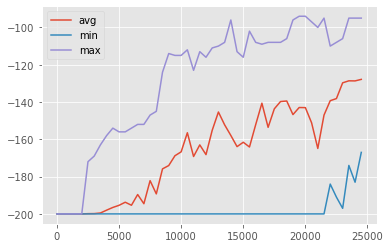

In [76]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="avg")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max")
plt.legend(loc=2)
plt.grid(True)
plt.show()

# Plotting the decisions

This plot shows how our model selected Q Values to use. Green values were considered optimal by the model, while red were suboptimal. Action 0 is "move left", Action 1 is "don't move", and Action 2 is "move right". We can also see how the maximum graph value is 40, as defined by our discrete_os_space variable.

Putting it all together, this graph shows us when it decided each of our actions was optimal. We can see that Action 1 (staying still) was rarely considered optimal. We can also see that Action 0 and Action 2 are clustered around different parts of the plot. This makes sense: the cart needs to gain momentum by swinging left and right, and it can only be optimal to perform one of these actions depending on which hill it's trying to climb.

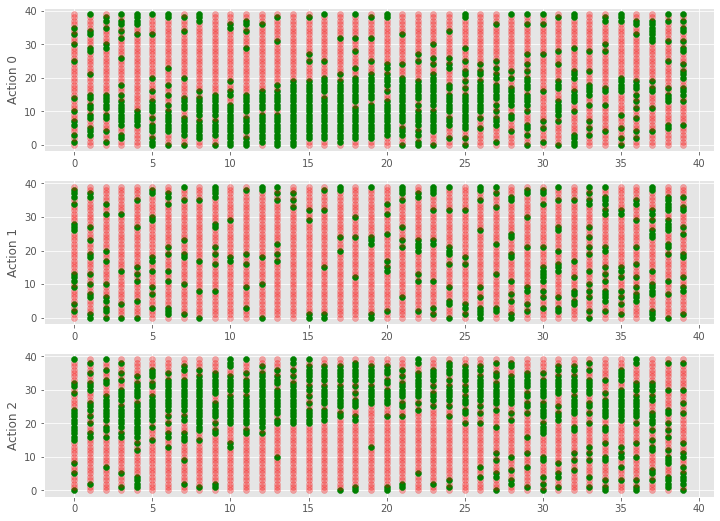

In [72]:
style.use('ggplot')


def get_q_color(value, vals):
    if value == max(vals):
        return "green", 1.0
    else:
        return "red", 0.3


fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

i = 24990 # the interation we want to use
q_table = np.load(f"qtables/{i}-qtable.npy")


for x, x_vals in enumerate(q_table):
    for y, y_vals in enumerate(x_vals):
        ax1.scatter(x, y, c=get_q_color(y_vals[0], y_vals)[0], marker="o", alpha=get_q_color(y_vals[0], y_vals)[1])
        ax2.scatter(x, y, c=get_q_color(y_vals[1], y_vals)[0], marker="o", alpha=get_q_color(y_vals[1], y_vals)[1])
        ax3.scatter(x, y, c=get_q_color(y_vals[2], y_vals)[0], marker="o", alpha=get_q_color(y_vals[2], y_vals)[1])

        ax1.set_ylabel("Action 0")
        ax2.set_ylabel("Action 1")
        ax3.set_ylabel("Action 2")


plt.show()